<a href="https://colab.research.google.com/github/andreacini/ml-19-20/blob/master/04_model_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

Prof. Cesare Alippi  
Andrea Cini  ([`andrea.cini@usi.ch`](mailto:daniele.grattarola@usi.ch)  )    
Daniele Zambon ([`daniele.zambon@usi.ch`](mailto:daniele.zambon@usi.ch)  )

---
# Lab 04: Model Performance

In [0]:
# --- Auxiliary code -------------------- #

# function to plot decision boundaries
def plot_decision_surface(model, x, y, transform=lambda x:x):
    
  from matplotlib.colors import ListedColormap
  # color_maps
  cm = plt.cm.RdBu
  cols = ['#FF0000', '#0000FF']
  cm_bright = ListedColormap(cols)  

  #init figure
  fig = plt.figure()

  # Create mesh
  h = .1  # step size in the mesh
  x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
  y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                       np.arange(y_min, y_max, h))

  # plot train data
  cy = [cols[int(yi)] for yi in y]
  plt.scatter(x[:, 0], x[:, 1], c=cy, cmap=cm_bright,
              edgecolors='k')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

  plt.xlabel(r'$x_1$')
  plt.ylabel(r'$x_2$');

  y_pred = model.predict(transform(np.c_[xx.ravel(), yy.ravel()]))

  y_pred = y_pred.reshape(xx.shape)
  plt.contourf(xx, yy, y_pred > 0.5, cmap=cm, alpha=.5)

## Use-case scenario
Let's pretend a company asked us to develop a machine learning model for one of their machinery. 

We are given some labelled data $(x_i, y_i)$ for $i=1, ..., N$, and asked to provide
- the best model $f(x; \hat \theta)$ we can find;
- an estimate of its performance $V(\hat \theta)$.

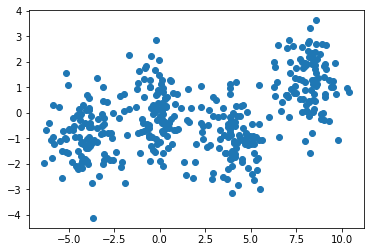

In [2]:
# Prepare some data
N = 400

import numpy as np
np.random.seed(200402)
Xa = np.random.randn(N//4, 2)
Xb = np.random.randn(N//4, 2) + np.array([ 8.,  1.])
Xc = np.random.randn(N//4, 2) + np.array([-4., -1.])
Xd = np.random.randn(N//4, 2) + np.array([ 4., -1.])

X = np.vstack([Xa, Xb, Xc, Xd])

import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1]);

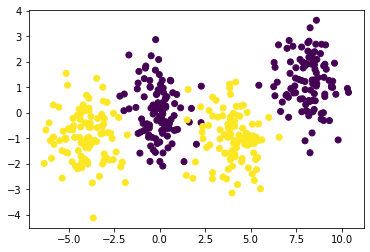

In [3]:
# Add labels
y = np.zeros((N,))
y[N//2:] = 1

plt.scatter(X[:, 0], X[:, 1], c=y);

## Train some models

Let's start from a logistic regression ([sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)).

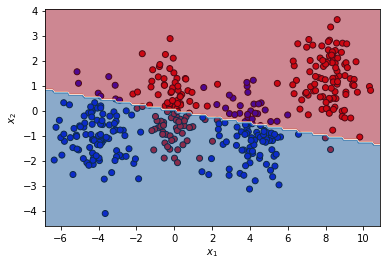

In [4]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X, y)

plot_decision_surface(model=logreg, x=X, y=y)

Let's try a feed-forward neural net ([keras doc](https://keras.io/models/sequential/)). 

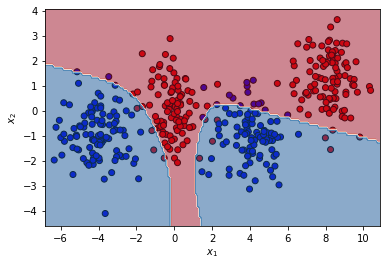

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy

def create_ffnn(neurons=3, activation="tanh"):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(2,), activation=activation))
    model.add(Dense(1, activation="sigmoid"))    
    model.compile(loss=BinaryCrossentropy(), metrics=["accuracy"])
    return model
epochs = 200

ffnn = create_ffnn() 
ffnn.fit(X, y, epochs=epochs, verbose=0)

plot_decision_surface(model=ffnn, x=X, y=y)

## Performance assessment

### Split the data: cross-validation

In [6]:
# Set sizes
n = int(N * .8)  # Training points
l = N - n        # Test points
print("num training points: n=",  n)
print("num test points:     l= ", l)

# Data split
X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

num training points: n= 320
num test points:     l=  80


LR acc   : 0.05
NN acc   : 0.0


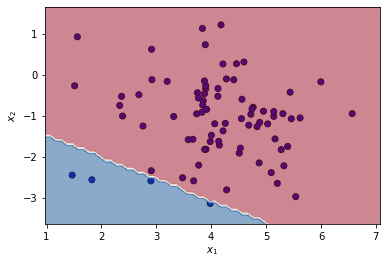

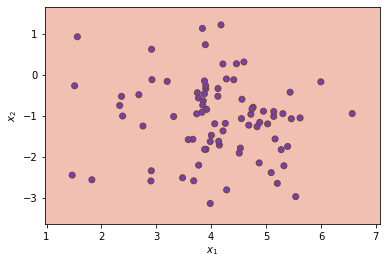

In [7]:
# Train the two models
#logistic
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
#nn
ffnn = create_ffnn() 
ffnn.fit(X_train, y_train, epochs=epochs, verbose=0)

# Accuracy: rate of correct classifications:
#logistic
correct_classif = (logreg.predict(X_test) == y_test).astype(int)
print("LR acc   :", np.mean(correct_classif))
#nn
y_pred = np.array(ffnn.predict(X_test) > .5, dtype=int)[:, 0]
correct_classif = (y_pred == y_test).astype(int)
print("NN acc   :", np.mean(correct_classif))

# Plot boundaries
plot_decision_surface(model=logreg, x=X_test, y=y_test)
plot_decision_surface(model=ffnn,   x=X_test, y=y_test)

#### What's wrong?

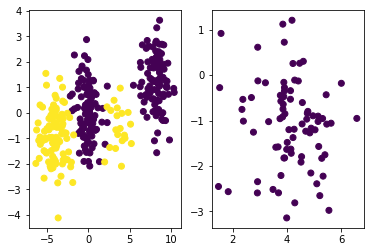

In [8]:
# Plot split data
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test);

We did not shuffled the data.

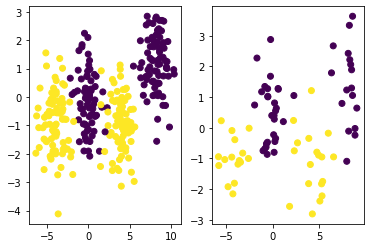

In [9]:
# Shuffle the data!
p = np.random.permutation(N)
idx_train = p[:n]
idx_test = p[n:]

# Data split
X_train, y_train = X[idx_train], y[idx_train]
X_test, y_test = X[idx_test], y[idx_test]

# Plot split data
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test);


SkLearn provides many [utilities](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection). For example, `train_test_split`, `ShuffleSplit` and `StratifiedShuffleSplit`.


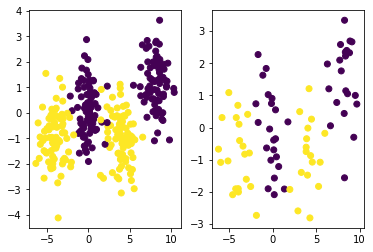

In [10]:
# or with SkLearn
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(np.arange(N), test_size=0.2, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Data split
X_train, y_train = X[idx_train], y[idx_train]
X_test, y_test = X[idx_test], y[idx_test]

# Plot split data
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test);

3/3 [==============================] - 0s 2ms/step - loss: 0.1285 - accuracy: 0.9625
acc_lr 0.725
acc_nn 0.9624999761581421


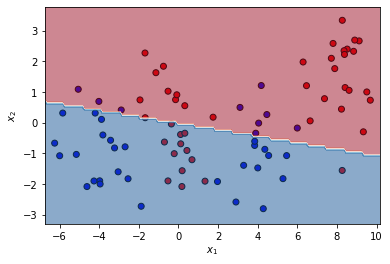

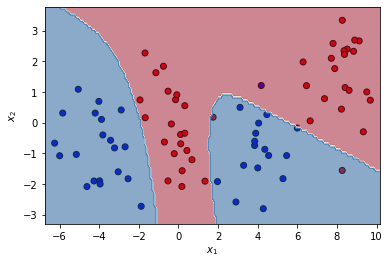

In [11]:
# Train the two models
#logistic
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
#nn
ffnn = create_ffnn(8) 
ffnn.fit(X, y, epochs=epochs, verbose=0)

# Evaluate accuracy
acc_lr = logreg.score(X_test, y_test)
[loss_nn, acc_nn] = ffnn.evaluate(X_test, y_test)
print("acc_lr", acc_lr)
print("acc_nn", acc_nn)

# Plot boundaries
plot_decision_surface(model=logreg, x=X_test, y=y_test)
plot_decision_surface(model=ffnn, x=X_test, y=y_test)

## Can we say which model is the best?


$$
e_i = 
\begin{cases}
1, & \text{if } y_i =   f(x_i;\hat \theta)\\
0, & \text{if } y_i \ne f(x_i;\hat \theta)
\end{cases}
$$

$$\overline e = \frac{1}{l}\sum_{i=1}^l e_i ;\qquad s^2 = \overline e (1 - \overline e)$$

$$T = \frac{\overline e_{nn} - \overline e_{lr}}
           {\sqrt{ \frac{s^2_{nn}}{l} + \frac{s^2_{lr}}{l}}}$$
           

In [12]:
# Logistic Regression part
e_lr = (y_test == logreg.predict(X_test)).astype(int)
mean_e_lr = e_lr.mean()
s2_lr = mean_e_lr * (1 - mean_e_lr)
print("mean: {} -- s2: {}".format(mean_e_lr, s2_lr))

# Neural Net part
y_pred = (ffnn.predict(X_test) > .5)[:, 0].astype(int)
e_nn = (y_test == y_pred).astype(int)
mean_e_nn = e_nn.mean()
s2_nn = mean_e_nn * (1 - mean_e_nn)
print("mean: {} -- s2: {}".format(mean_e_nn, s2_nn))

# Test statistics
T = (mean_e_nn - mean_e_lr) 
T /= np.sqrt( s2_nn / l + s2_lr / l )
print("is T={} in 95\% confidence interval (-1.96, 1.96) ?".format(T))

# t-test
from scipy.stats import ttest_ind
tt, p_val = ttest_ind(e_lr, e_nn, equal_var=False)
print('t-test: T={:.2f}, p-value={:.4f}'.format(tt, p_val))

# paired t-test
from scipy.stats import ttest_rel
tt, p_val = ttest_rel(e_lr, e_nn)
print('t-test: T={:.2f}, p-value={:.4f}'.format(tt, p_val))

mean: 0.725 -- s2: 0.199375
mean: 0.9625 -- s2: 0.03609374999999998
is T=4.377659396485641 in 95\% confidence interval (-1.96, 1.96) ?
t-test: T=-4.35, p-value=0.0000
t-test: T=-4.65, p-value=0.0000


## Did we finish?

- The best model was the neural net,
- We estimated its performance,
- ...

We retrain the best model on the entire dataset.


In [13]:
ffnn_final = create_ffnn()  # Remember: train the model from scratch.
ffnn_final.fit(X, y, epochs=epochs, verbose=0)

from tensorflow.keras.models import save_model 
save_model(ffnn_final, "my_final_model.tf")

from tensorflow.keras.models import load_model 
loaded_model = load_model("my_final_model.tf")

# Check they are actually the same
print(ffnn_final.evaluate(X, y))
print(loaded_model.evaluate(X, y))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_final_model.tf/assets
13/13 [==============================] - 0s 1ms/step - loss: 0.2251 - accuracy: 0.9450
[0.22505870461463928, 0.9449999928474426]
13/13 [==============================] - 0s 1ms/step - loss: 0.2251 - accuracy: 0.9450
[0.22505870461463928, 0.9449999928474426]


---


## K-fold cross-validation

Say we have a single model and we want to identify a confidence interval for its accuracy.


In [14]:
from sklearn.model_selection import StratifiedKFold

# Utility to split the data
kfcv = StratifiedKFold(n_splits=10, shuffle=True)
fold_iterator = kfcv.split(X, y)

# Utility to split the data
acc_nn = []

for idx_train, idx_val in fold_iterator:

    # split data
    X_train, y_train = X[idx_train], y[idx_train]
    X_val, y_val = X[idx_val], y[idx_val]

    # train model
    ffnn = create_ffnn(8)  # Remember: train the model from scratch.
    ffnn.fit(X_train, y_train, epochs=epochs, verbose=0)

    # evaluate model
    _, current_acc = ffnn.evaluate(X_val, y_val)
    acc_nn.append(current_acc)

print("Acc list:", acc_nn)
print("This is our estimated accuracy:  {:.3f} +- {:.3f}".format(np.mean(acc_nn), np.std(acc_nn)))

2/2 [==============================] - 0s 3ms/step - loss: 0.1898 - accuracy: 0.9500
Acc list: [0.875, 0.9750000238418579, 1.0, 0.949999988079071, 0.925000011920929, 0.9750000238418579, 0.925000011920929, 1.0, 0.9750000238418579, 0.949999988079071]
This is our estimated accuracy:  0.955 +- 0.037


Even from here we could have compared the two models.

In [15]:
# Utility to split the data
kfcv = StratifiedKFold(n_splits=10, shuffle=True)
fold_iterator = kfcv.split(X, y)

# Utility to split the data
acc_nn = []
acc_lr = []

for idx_train, idx_val in fold_iterator:

    X_train, y_train = X[idx_train], y[idx_train]
    X_val, y_val = X[idx_val], y[idx_val]

    ffnn = create_ffnn(8)  # Remember: train the model from scratch.
    ffnn.fit(X_train, y_train, epochs=epochs, verbose=0)

    logreg = LogisticRegression() 
    logreg.fit(X_train, y_train)

    _, current_acc = ffnn.evaluate(X_val, y_val)
    acc_nn.append(current_acc)
    current_acc = logreg.score(X_val, y_val)
    acc_lr.append(current_acc)

print("LogReg list:   ", acc_lr)
print("NeuralNet list:", acc_nn)

print("LogReg:     {:.3f} +- {:.3f}".format(np.mean(acc_lr), np.std(acc_lr)))
print("NeuralNet:  {:.3f} +- {:.3f}".format(np.mean(acc_nn), np.std(acc_nn)))

# Paired two sample test
T, p_val = ttest_rel(acc_lr, acc_nn)
print('t-test: T={:.2f}, p-value={:.4f}'.format(tt, p_val))
print("is T={:.2f} in 95\% confidence interval (-1.96, 1.96) ?".format(T))

2/2 [==============================] - 0s 3ms/step - loss: 0.2566 - accuracy: 0.9500
LogReg list:    [0.65, 0.725, 0.725, 0.9, 0.85, 0.875, 0.675, 0.825, 0.775, 0.775]
NeuralNet list: [0.949999988079071, 0.8999999761581421, 1.0, 0.9750000238418579, 1.0, 1.0, 0.925000011920929, 0.925000011920929, 0.949999988079071, 0.949999988079071]
LogReg:     0.778 +- 0.080
NeuralNet:  0.957 +- 0.034
t-test: T=-4.65, p-value=0.0000
is T=-7.66 in 95\% confidence interval (-1.96, 1.96) ?




---


## More than two models and hyper-parameter tuning

In [0]:
# neurons - activation
model_parameters = [(3, "tanh"), 
                    (3, "relu"), 
                    (6, "tanh"), 
                    (6, "relu")]  

### Data split

```
|               Entire data (N)               |
|---------------------------------------------|

|          Training data          | Test data |
|---------------------------------|-----------|

|          Training data          | Test data |
| Actual fitting data  | Val.data |           |
|----------------------|----------|-----------|
```

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

X_atr, X_val, y_atr, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)

# Model selection
acc_list = []
for (neurons, activation) in model_parameters:
    print("Training NN with {} neurons and {} epochs".format(neurons, epochs))

    model = create_ffnn(neurons=neurons, activation=activation)
    model.fit(X_atr, y_atr, epochs=epochs, verbose=0)

    acc = model.evaluate(X_val, y_val)
    acc_list.append(acc)

imax = np.argmax(acc)
print("Best model parameters:", model_parameters[imax])

# Performance of best model
(neurons, activation) = model_parameters[imax]
best_model = create_ffnn(neurons=neurons, activation=activation)
best_model.fit(X_train, y_train, epochs=epochs, verbose=0)
_, final_acc = best_model.evaluate(X_test, y_test)
print("Best model accuracy:", final_acc)

# Final trained model
final_model = create_ffnn(neurons=neurons, activation=activation)
final_model.fit(X, y, epochs=epochs, verbose=0)

Training NN with 3 neurons and 200 epochs
3/3 [==============================] - 0s 2ms/step - loss: 0.4658 - accuracy: 0.7500
Training NN with 3 neurons and 200 epochs
3/3 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7500
Training NN with 6 neurons and 200 epochs
3/3 [==============================] - 0s 3ms/step - loss: 0.3411 - accuracy: 0.8690
Training NN with 6 neurons and 200 epochs
3/3 [==============================] - 0s 3ms/step - loss: 0.4079 - accuracy: 0.7381
Best model parameters: (3, 'relu')
4/4 [==============================] - 0s 2ms/step - loss: 0.3204 - accuracy: 0.9167
Best model accuracy: 0.9166666865348816
